Imbalanced data is frequently encountered in real world settings and poses a problem to many machine learning algorithms. Therefore, many strategies have been developed to deal with imbalanced data sets. This notebook outlines how threshold shifting can be used to deal with class imbalance in binary classification problems. First, we will create an imbalanced dummy data set for binary classification:

In [1]:
from functools import partial
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, Bounds
from sklearn.calibration import CalibrationDisplay, calibration_curve
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, fbeta_score, make_scorer
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

X, y = make_classification(n_samples=40000, n_features=5, n_redundant=1, n_clusters_per_class=1, 
                           weights=[0.95], class_sep=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Not considering class imbalance
For baseline comparison, we will train a random forest on this data set without any special consideration for class imbalance:

In [2]:
pipe1 = Pipeline(steps=[("classifier", RandomForestClassifier())])
param_grid1 = {"classifier__max_depth": [16, 18, 20, 22]}
f2_scorer = make_scorer(fbeta_score, beta=2)
grid1 = GridSearchCV(estimator=pipe1, param_grid=param_grid1, cv=5, scoring=f2_scorer)
model1 = grid1.fit(X_train, y_train)

print(f"Following hyperparameters were found to give best results: {model1.best_params_}")

Following hyperparameters were found to give best results: {'classifier__max_depth': 18}


Now, let's have a look at the confusion matrix and set a scenario. The data set is about predicting a serious medical condition. Accuracy is obviously not a good metric for this scenario, because it can be most easily improved by (correct) prediction of healthy individuals (as there are much more healthy than sick individuals). However, healthy individuals are not our main interest. The cost/real world consequences of our predictions can be quite divergent from what the accuracy score is optimizing for.

Because the condition is quite serious, we really want to identify as many of the truely sick patients as possible (=focus on sensitivity). On the other hand, there are also consequences on neglecting precision for sensitivity: A therapy initiated based on our prediction may have severe side effects. We would not want to unnecessarily subject healthy individuals to this therapy. However, for now let's assume that the focus is somewhat more on the sensitivity side and as a result we decide to use a Fbeta score with beta=2 (=F2 score) to account for this.

As we can see our random forest fails to account for these consideration due to the class imbalance and achieves a F2 score of only 0.24. The precision is way better than the sensitivity:

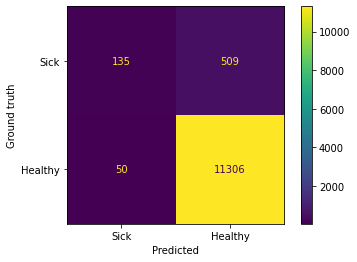

In [3]:
y_test_pred_m1 = model1.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred_m1, labels=[1,0])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0,1], ["Sick", "Healthy"])
plt.yticks([0,1], ["Sick", "Healthy"])
plt.ylabel("Ground truth")
plt.xlabel("Predicted")
plt.show()

In [4]:
accuracy = accuracy_score(y_test, y_test_pred_m1)
sensitivity = recall_score(y_test, y_test_pred_m1)
precision = precision_score(y_test, y_test_pred_m1)
f2_score = fbeta_score(y_test, y_test_pred_m1, beta=2)

print(f"""Accuracy: {round(accuracy, 3)}
Sensitivity: {round(sensitivity, 3)}
Precision: {round(precision, 3)}
F2 score: {round(f2_score, 3)}""")

Accuracy: 0.953
Sensitivity: 0.21
Precision: 0.73
F2 score: 0.244


However, the good news is that our model is able to output well calibrated probabilities:

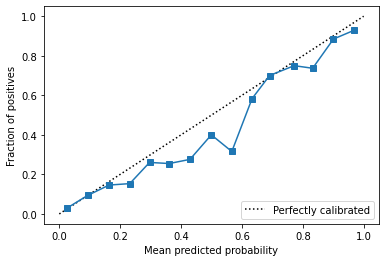

In [5]:
y_test_pred_proba_m1 = model1.predict_proba(X_test)[:, 1]
prob_true_m1, prob_pred_m1 = calibration_curve(y_test, y_test_pred_proba_m1, n_bins=15)
disp = CalibrationDisplay(prob_true_m1, prob_pred_m1, y_test_pred_proba_m1)
disp.plot()

# Considering class imbalance by oversampling
A very popular method for overcoming problems associated with class imbalance is SMOTE (Synthetic Minority Over-sampling Technique, https://arxiv.org/pdf/1106.1813.pdf). Compared to random oversampling, the creation of new synthetic minority class samples prevents overfitting. However, some shortcomings also exist. E.g., because SMOTE uses a nearest neighbor approach for creating new synthetic minority class samples, it is not suited for high-dimensional data sets. Furthermore, the newly created synthetic minority class samples may be derived from noisy samples in the minority class, thereby creating additional noise. But on this data set incorporating SMOTE into our training workflow significiantly improves our F2 score:

In [6]:
pipe2 = imbPipeline(steps=[("smote", SMOTE()),
                           ("classifier", RandomForestClassifier())])
param_grid2 = {"smote__k_neighbors": [5, 7, 9, 11],
               "classifier__max_depth": [4, 5, 6, 7]}

grid2 = GridSearchCV(estimator=pipe2, param_grid=param_grid2, cv=5, scoring=f2_scorer)
model2 = grid2.fit(X_train, y_train)

print(f"Following hyperparameters were found to give best results: {model2.best_params_}")

Following hyperparameters were found to give best results: {'classifier__max_depth': 5, 'smote__k_neighbors': 7}


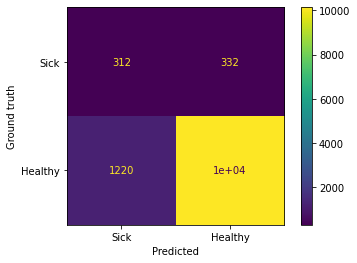

In [7]:
y_test_pred_m2 = model2.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred_m2, labels=[1,0])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0,1], ["Sick", "Healthy"])
plt.yticks([0,1], ["Sick", "Healthy"])
plt.ylabel("Ground truth")
plt.xlabel("Predicted")
plt.show()

In [8]:
accuracy = accuracy_score(y_test, y_test_pred_m2)
sensitivity = recall_score(y_test, y_test_pred_m2)
precision = precision_score(y_test, y_test_pred_m2)
f2_score = fbeta_score(y_test, y_test_pred_m2, beta=2)

print(f"""Accuracy: {round(accuracy, 3)}
Sensitivity: {round(sensitivity, 3)}
Precision: {round(precision, 3)}
F2 score: {round(f2_score, 3)}""")

Accuracy: 0.871
Sensitivity: 0.484
Precision: 0.204
F2 score: 0.38


However, we must be aware that by incorporating SMOTE into our workflow, the model is no longer able to output well calibrated probabilities:

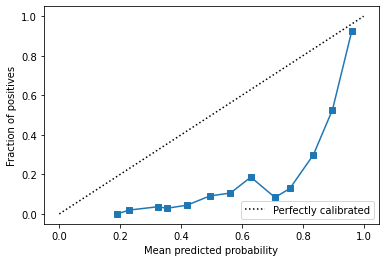

In [9]:
y_test_pred_proba_m2 = model2.predict_proba(X_test)[:, 1]
prob_true_m2, prob_pred_m2 = calibration_curve(y_test, y_test_pred_proba_m2, n_bins=15)
disp = CalibrationDisplay(prob_true_m2, prob_pred_m2, y_test_pred_proba_m2)
disp.plot()

# Considering class imbalance by threshold shifting
Another possibility is to simply train a model without consideration of class imbalance (as we did in the first part of this notebook) and subsequently shift the decision threshold away from the default value of 0.5. The class below implements means to find a new optimal threshold:

In [10]:
class ThresholdFinder():
    def _objective_function(self, threshold, model, X, y, y_pred_proba, scoring_function, n_splits, n_repeats, seed):
        scores = []
        rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
        for idxs, _ in rskf.split(X, y):
            y_split = y[idxs]
            y_pred_proba_split = y_pred_proba[idxs]
            y_pred_split = (y_pred_proba_split > threshold).astype("int")
            scores.append(scoring_function(y_split, y_pred_split))
        
        score = np.median(scores)
        return -score
    
    def find_threshold(self, model, X, y, scoring_function, n_splits=5, n_repeats=5, seed=1):
        y_pred_proba = model.predict_proba(X)[:, 1]
        objective_function = partial(self._objective_function, model=model, X=X, y=y,  y_pred_proba=y_pred_proba, 
                                     scoring_function=scoring_function, n_splits=n_splits, n_repeats=n_repeats, seed=seed)
        
        result = minimize(fun=objective_function,
                          method="Nelder-Mead",
                          x0=0.5,
                          bounds=Bounds(0,1),
                          options={"maxfev": 50})        
        return result.x[0]

Let's find our new threshold:

In [11]:
f2_score = partial(fbeta_score, beta=2)
threshold = ThresholdFinder().find_threshold(model1, X_train, y_train, f2_score)
print(f"The new threshold is: {round(threshold, 3)}")

The new threshold is: 0.112


Let's evaluate the performance. As we can see, we achieve similiar results to the previously outlined SMOTE workflow:

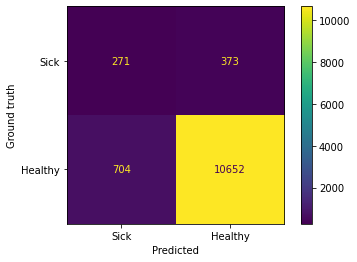

In [12]:
y_test_pred_proba_m1 = model1.predict_proba(X_test)[:, 1]
y_test_pred_m1 = (y_test_pred_proba_m1 > threshold).astype("int")
cm = confusion_matrix(y_test, y_test_pred_m1, labels=[1,0])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0,1], ["Sick", "Healthy"])
plt.yticks([0,1], ["Sick", "Healthy"])
plt.ylabel("Ground truth")
plt.xlabel("Predicted")
plt.show()

In [13]:
accuracy = accuracy_score(y_test, y_test_pred_m1)
sensitivity = recall_score(y_test, y_test_pred_m1)
precision = precision_score(y_test, y_test_pred_m1)
f2_score = fbeta_score(y_test, y_test_pred_m1, beta=2)

print(f"""Accuracy: {round(accuracy, 3)}
Sensitivity: {round(sensitivity, 3)}
Precision: {round(precision, 3)}
F2 score: {round(f2_score, 3)}""")

Accuracy: 0.91
Sensitivity: 0.421
Precision: 0.278
F2 score: 0.382


A drawback of this approach is that special consideration must be taken when extending this idea to multiclass classification.